# Introduction: Bayesian Optimization using Hyperopt

There are four parts to an optimization problem:

1. Objective: what we want to minimize
2. Domain: values of the parameters over which to minimize the objective
3. Hyperparameter optimization function: how the next values to evalute are proposed
4. Trials consisting of score, parameters pairs

Bayesian optimization differs from random or grid search in part 3: rather than just choosing from a grid uninformed by past function evaluations, Bayesian methods take into accout the previous results to try more promising values. In this notebook, we will implement both random search (Hyperopt has a method for this) as well as the Tree Parzen Estimator, a Sequential Model-Based Optimization method. 

## Hyperopt

Hyperopt is an open-source Python library for Bayesian optimization. There are a number of libraries available for Bayesian optimization and Hyperopt differs in that it is the only one to currently offer the Tree Parzen Estimator. Other libraries use a Gaussian Process or a Random Forest regression for the surrogate function (probability model). 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Objective


For our objective function, we will use a fairly simple polynomial function defined over the range -6 to 5. The objective is to find the minimum of this function. There is one local minimum that could given an optimization algorithm issues.

In [2]:
def objective(x):
    """Objective function to minimize"""
    
    # Create the polynomial object
    f = np.poly1d([1, -2, -26, 28, 145, -26, -80])

    # Return the value associated with x
    return 0.01 * f(x)

### Visualization of Function

To get a sense of what we are trying to optimize, it's helpful to look at the objective function. We will only evaluate the objective function from -4 to 5

Minimum of -7.9405 occurs at 4.3384


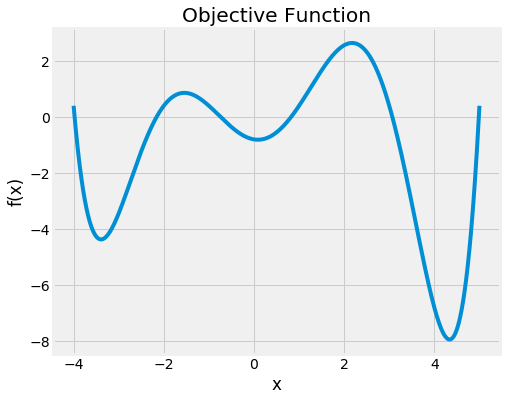

In [3]:
# Space over which to evluate the function is -4 to 5
x = np.linspace(-4, 5, 10000)
y = objective(x)


plt.figure(figsize = (8, 6))
plt.style.use('fivethirtyeight')
plt.title('Objective Function'); plt.xlabel('x'); plt.ylabel('f(x)')
plt.plot(x, y);

# Print out the minimum of the function and value
print('Minimum of %0.4f occurs at %0.4f' % (min(y), x[np.argmin(y)]))

# Domain

The domain is the values of x over which we evaluate the function. In this case, it makes sense to use a uniform distribution where the likelihood of each value is equal.

In [4]:
from hyperopt import hp

# Create the domain space
space = hp.uniform('x', -4, 5)

We can draw samples from the space using a Hyperopt utility. This is useful for visualizing a distribution.

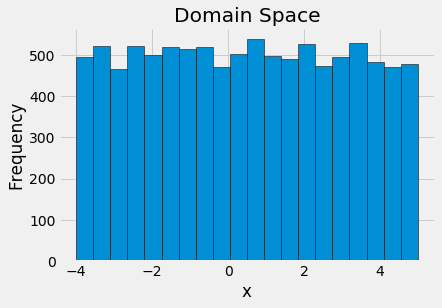

In [5]:
from hyperopt.pyll.stochastic import sample


samples = []

for _ in range(10000):
    samples.append(sample(space))
    

plt.hist(samples, bins = 20, edgecolor = 'black'); 
plt.xlabel('x'); plt.ylabel('Frequency'); plt.title('Domain Space');

# Hyperparameter Optimization Algorithm

There are two choices for a hyperparameter optimization algorithm in Hyperopt: random and Tree Parzen Estimator. We can use both and compare the results. Using the `suggest` algorithm in these families automatically configures the algorithm for us. Otherwise we can modify the algorithm if we know what we are doing! 

In [6]:
from hyperopt import rand, tpe

# Create the algorithms
tpe_algo = tpe.suggest
rand_algo = rand.suggest

# History

Storing the history is as simple as making a `Trials` object that we pass into the function call. 

In [7]:
from hyperopt import Trials

tpe_trials = Trials()
rand_trials = Trials()

# Run the Optimization

Now that all four parts are in place, we are ready to minimize! Let's do 1000 runs of the minimization with both the random algorithm and the Tree Parzen Estimator algorithm. The `fmin` function takes in exactly the four parts specified above as well as the maximum number of evaluations to run. 

In [8]:
from hyperopt import fmin

In [9]:
# Run 1000 evals with the tpe algorithm
tpe_best = fmin(fn=objective, space=space, algo=tpe_algo, trials=tpe_trials, max_evals=1000, rstate= np.random.RandomState(50))

In [10]:
%%timeit -n 3
# Run 1000 evals with the tpe algorithm
fmin(fn=objective, space=space, algo=tpe_algo, trials=tpe_trials, max_evals=1000)

1.51 ms ± 439 µs per loop (mean ± std. dev. of 7 runs, 3 loops each)


In [11]:
# Run 1000 evals with the random algorithm
rand_best = fmin(fn=objective, space=space, algo=rand_algo, trials=rand_trials, max_evals=1000, rstate= np.random.RandomState(50))

In [12]:
%%timeit -n 3


# Run 1000 evals with the random algorithm
fmin(fn=objective, space=space, algo=rand_algo, trials=rand_trials, max_evals=1000)

2.16 ms ± 510 µs per loop (mean ± std. dev. of 7 runs, 3 loops each)


As a point of interest, the random algorithm ran about 5 times faster than the tpe algorithm. This shows that the TPE method is taking more time to propose the next set of hyperparameters (while the random method is just choosing from the space randomly). The extra time to choose the next hyperparameters is made up for by choosing better hyperparameters that let us make fewer overall calls to the objective function (which is the most expensive part of optimization).

In [13]:
print('Minimum loss attained with TPE:    {:.4f}'.format(tpe_trials.best_trial['result']['loss']))
print('Minimum loss attained with random: {:.4f}'.format(rand_trials.best_trial['result']['loss']))
print('Actual minimum of f(x):            {:.4f}'.format(min(y)))

print('\nNumber of trials needed to attain minimim with TPE:    {}'.format(tpe_trials.best_trial['misc']['idxs']['x'][0]))
print('Number of trials needed to attain minimim with random: {}'.format(rand_trials.best_trial['misc']['idxs']['x'][0]))

print('\nBest value of x from TPE:    {:.4f}'.format(tpe_best['x']))
print('Best value of x from random: {:.4f}'.format(rand_best['x']))
print('Actual best value of x:      {:.4f}'.format(x[np.argmin(y)]))

Minimum loss attained with TPE:    -7.9405
Minimum loss attained with random: -7.9405
Actual minimum of f(x):            -7.9405

Number of trials needed to attain minimim with TPE:    14
Number of trials needed to attain minimim with random: 14

Best value of x from TPE:    4.3390
Best value of x from random: 4.3390
Actual best value of x:      4.3384


# Results

We see that both models returned values very close to the optimal. To see how they differ in the search procedure, we can take a look at the trials objects. 

In [14]:
tpe_results = pd.DataFrame({'loss': [x['loss'] for x in tpe_trials.results], 'iteration': tpe_trials.idxs_vals[0]['x'],
                            'x': tpe_trials.idxs_vals[1]['x']})
                            
tpe_results.head()

,loss,iteration,x
0,-0.600581,0,4.965542
1,-5.048743,1,3.748906
2,1.678833,2,2.724606
3,-0.568087,3,-0.331157
4,-0.777010,4,-3.931954


Extracting these results was a little work. We could have formatted the objective function to return more useful information as well (in a little bit we can see how to do this).

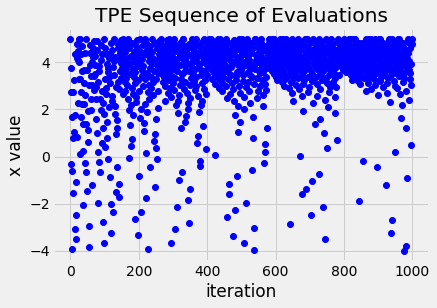

In [15]:
plt.plot(tpe_results['iteration'], tpe_results['x'], 'bo');
plt.xlabel('iteration'); plt.ylabel('x value'); plt.title('TPE Sequence of Evaluations');

We can see that over time, the algorithm tended to try values closer to 4. The local minimum around -4 likely threw off the algorithm, but the points tend to cluster around the actual minimum as the algorithm progresses. Let's also plot the losses versus number of iterations.

In [16]:
# Sort with best loss first
tpe_results = tpe_results.sort_values('loss', ascending = True).reset_index()

Best Loss of -7.9405 occured at iteration 14


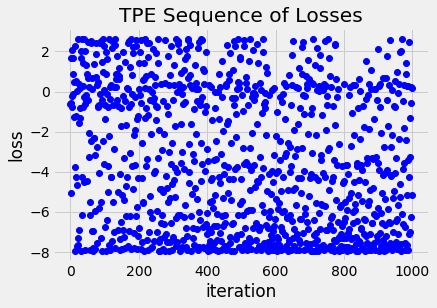

In [17]:
plt.plot(tpe_results['iteration'], tpe_results['loss'], 'bo');
plt.xlabel('iteration'); plt.ylabel('loss'); plt.title('TPE Sequence of Losses');

print('Best Loss of {:.4f} occured at iteration {}'.format(tpe_results['loss'][0], tpe_results['iteration'][0]))

In [18]:
rand_results = pd.DataFrame({'loss': [x['loss'] for x in rand_trials.results], 'iteration': rand_trials.idxs_vals[0]['x'],
                            'x': rand_trials.idxs_vals[1]['x']})
                            
rand_results.head()

,loss,iteration,x
0,-0.600581,0,4.965542
1,-5.048743,1,3.748906
2,1.678833,2,2.724606
3,-0.568087,3,-0.331157
4,-0.777010,4,-3.931954


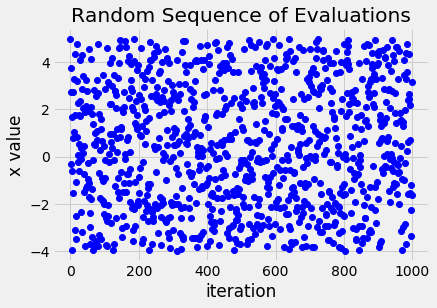

In [19]:
plt.plot(rand_results['iteration'], rand_results['x'], 'bo');
plt.xlabel('iteration'); plt.ylabel('x value'); plt.title('Random Sequence of Evaluations');
plt.show()

Clearly, the random algorithm is just well "randomly" choosing the next set of values to try! There is no logical order here!

Best Loss of -7.9405 occured at iteration 14


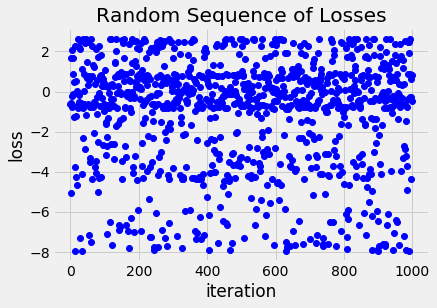

In [20]:
# Sort with best loss first
rand_results = rand_results.sort_values('loss', ascending = True).reset_index()

# Plot loss versus iterations
plt.plot(rand_results['iteration'], rand_results['loss'], 'bo');
plt.xlabel('iteration'); plt.ylabel('loss'); plt.title('Random Sequence of Losses');

# Print information
print('Best Loss of {:.4f} occured at iteration {}'.format(rand_results['loss'][0], rand_results['iteration'][0]))

# Conclusions

In this notebook, we saw a basic implementation of Bayesian hyperparameter optimization using Hyperopt. This requires four parts:

1. Objective: what we want to minimize
2. Domain: values of the parameters over which to minimize the objective
3. Hyperparameter optimization function: how the next values to evalute are proposed
4. Trials consisting of score, parameters pairs

The differences between random search and Tree Parzen Estimator are clear: random search chooses the next values in less time, but takes more trials to find the optimum value of the function because it does not choose values in an informed manner. In contrast, the Tree Parzen method is able to find a lower overall value of the objective function in fewer iterations.

This notebook showed only the basic implementation of Bayesian Hyperparameter optimization, but already we can see how it has significant advantages over random or grid search based methods. In future notebooks we will look at using Bayesian optimization on more complex problems, namely hyperparameter optimization of machine learning models. 